<a href="https://colab.research.google.com/github/jameswrbrookes/cc-nlp-tutorials/blob/main/sentiment_classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Google Drive Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# Packages

We will use the following packages in this notebook:

In [ ]:
import numpy as np
import pandas as pd
import sklearn
import matplotlib.pyplot as plt
import re
import random
import string
import tensorflow as tf

# Goal

The goal is to build a performant sentiment analysis system, which classifies movie reviews as `positive` or `negative`.  

To do that, we will need at the very minimum some training data, some featurization of the data, a model, and an evaluation metric.  

# Data and Data Exploration

We will use a sample of [Maas et al. (2011)](https://ai.stanford.edu/~ang/papers/acl11-WordVectorsSentimentAnalysis.pdf) IMDB dataset.  Their original dataset contains 25,000 labeled training observations, 25,000 labeled test observations, and 50,000 unlabeled observations.  We use a sample of 10,000 labeled training observations, which have themselves been split 60/20/20 into train/dev/test sets. Duplicates have been removed, but the text has otherwise not been preprocessed.

In [ ]:
imdb = pd.read_parquet('/content/drive/MyDrive/imdb-data/imdb-sample.parquet')

In [ ]:
imdb

,text,label,split
0,While the idea is more original than most Sci-...,neg,train
1,I had a lot of expectations from this movie an...,neg,train
2,I had heard some bad things about Cabin Fever ...,neg,train
3,Ohhh man! Now this is what I'm talking about! ...,neg,train
4,You got to go and dig those holes. Holes only ...,pos,train
...,...,...,...
9995,I really felt cheated after seeing this pictur...,neg,test
9996,"Now look, I won't lie to you, but I only got t...",neg,test
9997,The Color Purple is about the struggles of lif...,pos,test
9998,Have you heard the story about the reluctant h...,pos,test


## Check how many observations we have for each split

In [ ]:
imdb['split'].value_counts()

split
train    6000
dev      2000
test     2000
Name: count, dtype: int64

## Look at the distribution of the labels

In [ ]:
(imdb.groupby('split')['label'].value_counts(normalize = True) * 100).round(1)

split  label
dev    pos      50.8
       neg      49.2
test   neg      50.5
       pos      49.5
train  neg      50.5
       pos      49.5
Name: proportion, dtype: float64

## Split into separate dataframes

We will train our models on the `train`, look at intermediate results using `dev` (which could then iteratively inform features for retraining), and finally evaluate on `test` at the very end.

In [ ]:
train_imdb = imdb[imdb.split == 'train'].drop("split", axis = 1)
dev_imdb = imdb[imdb.split == 'dev'].drop("split", axis = 1)
test_imdb = imdb[imdb.split == 'test'].drop("split", axis = 1)

## Look at some interesting attributes of the data

Now we look at some interesting attributes of the data.  But, we will only consider the training data, as the exploratory stage can often give us insight into what kind of features might help our classifiers.  

## Look at the text of some examples

In [ ]:
train_imdb[train_imdb['label'] == "pos"]["text"]

4       You got to go and dig those holes. Holes only ...
5       As a huge fan of the original, I avoided this ...
8       The 74th Oscars was a very good one. Whoopi's ...
11      This is a sublime piece of film-making. It flo...
13      "A Thief in the Night" is a film that was gene...
                              ...                        
5989    I really enjoyed the detail that went into the...
5993    Recap: Zandalee is a young woman that feels mo...
5996    I was dragged to this movie about four years a...
5998    I loved this movie. It is a definite inspirati...
5999    Burlinson and Thornton give an outstanding per...
Name: text, Length: 2972, dtype: object

In [ ]:
print("POSITIVE REVIEWS ========================================================\n")
for example in train_imdb[train_imdb['label'] == "pos"]["text"].sample(5, random_state = 123):
  print(example)
  print('\n----------------------------------------------------------------------\n')

print("\n\n\nNEGATIVE REVIEWS ========================================================\n")
for example in train_imdb[train_imdb['label'] == "neg"]["text"].sample(5, random_state = 123):
  print(example)
  print('\n----------------------------------------------------------------------\n')

POSITIVE REVIEWS ========================================================

There are good ways to make a movie and bad ways and this very much the former. This short caper exacts nothing more than what it gives to the audience. It presents a simple story, told very plainly with enough wisecracks to keep you going, then just gets better and better. Clooney's cameo is funny and very welcome but the leads including Sam Rockwell and Luiz Guzman can easily make it on their own. Likeable and funny, hilariously so towards the end, Welcome to Collinwood is a welcome addition to the heist genre.

----------------------------------------------------------------------

Spacecamp is a movie that I plan to show my Daughter Julia Ann Ruth Morgan some day. Seeing Joaquin Phoenix in this movie makes you realize how far hes come since playing a Roman Emperor in the film Gladiator. I am pleased to say that I now have comms with the Artificial Intelligence of QE2 who said that I was Young and that is tru

In [ ]:
markup_ptn = re.compile(r"<[a-z]+ />")

markup_types = []

for example in train_imdb['text']:
  markup_types.extend(markup_ptn.findall(example))


In [ ]:
set(markup_types)

{'<br />'}

So in practice we should probably remove this. (We'll just pretend we've done it here)

### Length of reviews

In [ ]:
def get_num_words(r):
  return len(str(r).split())

In [ ]:
pos_review_lengths = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_num_words)
neg_review_lengths = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_num_words)

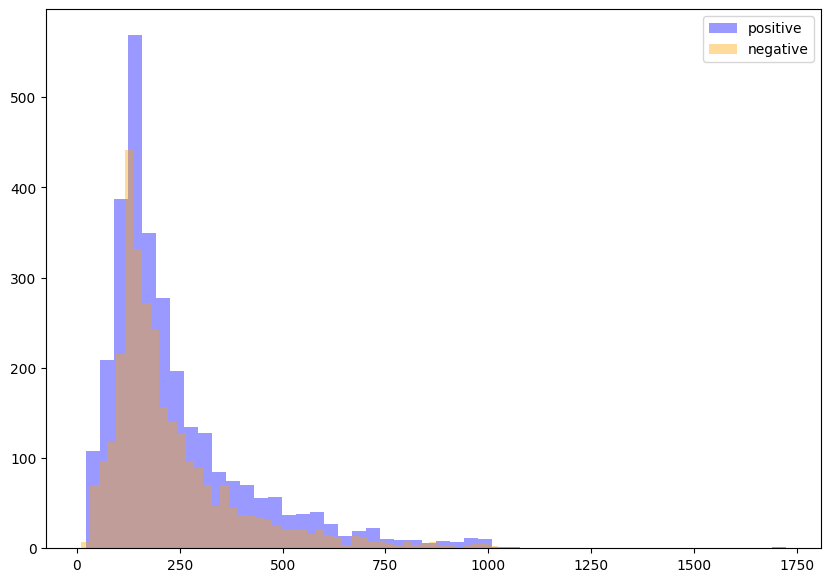

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_lengths, bins = 50, alpha = 0.4, color = 'blue')
plt.hist(neg_review_lengths, bins = 50, alpha = 0.4, color = 'orange')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean length of positive reviews is {np.mean(pos_review_lengths):.2f} words")
print(f"The mean length of negative reviews is {np.mean(neg_review_lengths):.2f} words")

The mean length of positive reviews is 238.61 words
The mean length of negative reviews is 228.95 words


In [ ]:
print(f"97.5% of positive reviews is {np.quantile(pos_review_lengths, q = .95):.2f} words")
print(f"97.5% of negative reviews is {np.quantile(neg_review_lengths, q = .95):.2f} words")

97.5% of positive reviews is 608.80 words
97.5% of negative reviews is 571.95 words


### Frequency of negation

In [ ]:
def get_negation_rate(r):

  split_r = r.split()
  neg_r = [1 for word in split_r if word.lower() in ["not", "yet", "hardly", "never", "no", "nowhere", "nobody"]]
  reduced_neg_r = re.findall("n't", r.lower())

  return (len(neg_r) + len(reduced_neg_r)) / len(split_r) * 10**6


In [ ]:
pos_review_neg_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_negation_rate)
neg_review_neg_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_negation_rate)

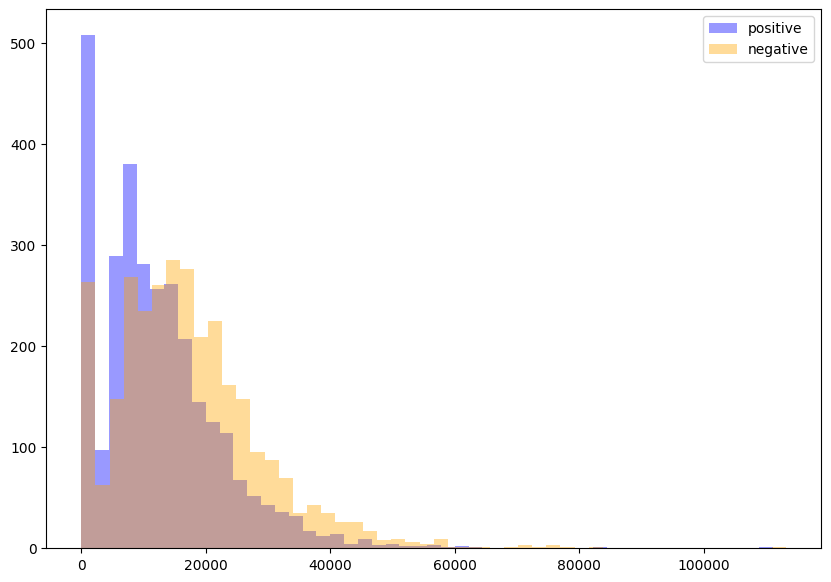

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_neg_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_neg_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean rate of negation in positive reviews is {np.mean(pos_review_neg_rate):.2f} per million words")
print(f"The mean rate of negation in negative reviews is {np.mean(neg_review_neg_rate):.2f} per million words")

The mean rate of negation in positive reviews is 12189.94 per million words
The mean rate of negation in negative reviews is 17187.28 per million words


In [ ]:
re.findall("n't", "do like that one very much and that one is")

[]

### Downtoners

In [ ]:
def num_downtoners(r):

  num_words = len(r.split())
  num_dt = len(re.findall(r'(somewhat|kinda|kind of|sorta|sort of|a bit|a little bit|slighly|only just|ish)\b', r.lower()))

  return num_dt / num_words * 10**6

In [ ]:
pos_review_happy_emoji_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(num_downtoners)
neg_review_happy_emoji_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(num_downtoners)

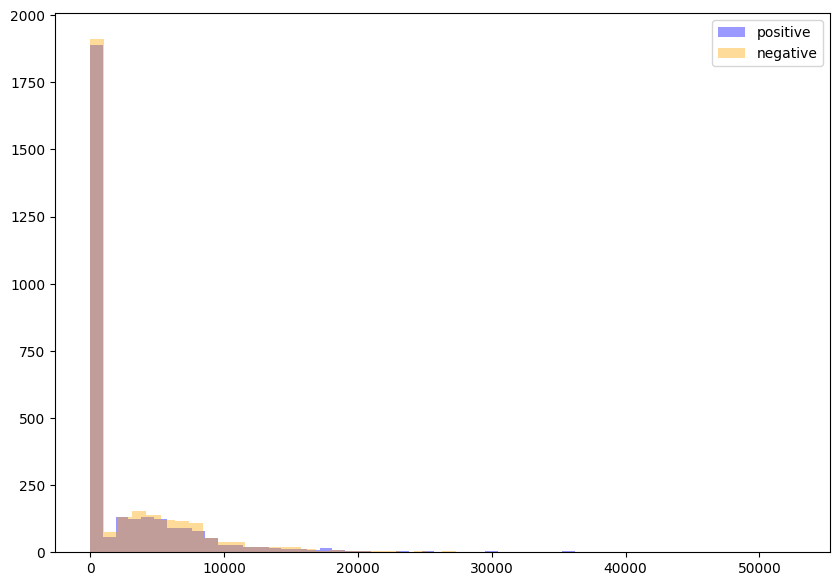

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_happy_emoji_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_happy_emoji_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

### First person references

In [ ]:
def get_first_person_refs(r):

  split_r = r.split()
  first_r = [1 for word in split_r if word.lower() in ["i", "me", "myself", "mine", "i'm", "i've", "i'd"]]

  return len(first_r) / len(split_r) * 10**6

In [ ]:
pos_review_first_person_rate = train_imdb[train_imdb['label'] == 'pos']['text'].apply(get_first_person_refs)
neg_review_first_person_rate = train_imdb[train_imdb['label'] == 'neg']['text'].apply(get_first_person_refs)

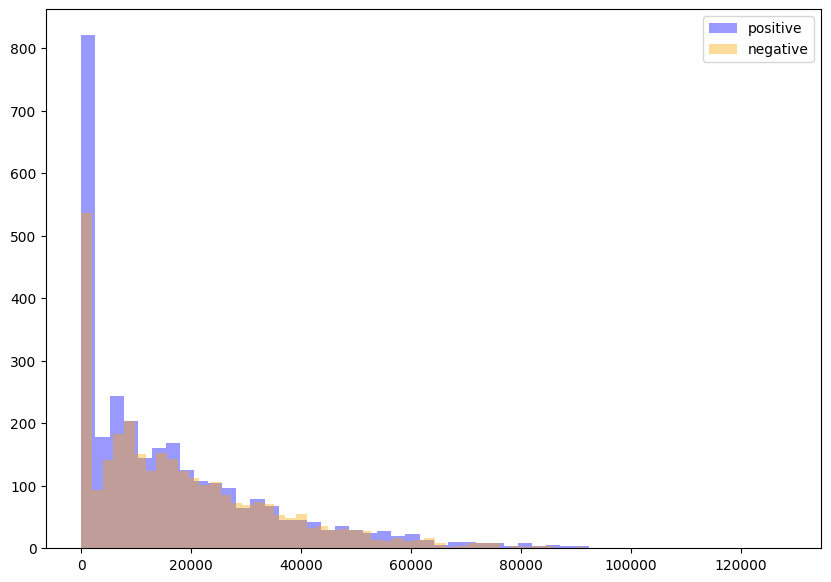

In [ ]:
plt.figure(figsize = (10,7))
plt.hist(pos_review_first_person_rate, bins = 50, alpha = 0.4, color = 'blue', label = 'positive')
plt.hist(neg_review_first_person_rate, bins = 50, alpha = 0.4, color = 'orange', label = 'negative')
plt.legend(["positive", "negative"])

In [ ]:
print(f"The mean rate of 1st person refs in positive reviews is {np.mean(pos_review_first_person_rate):.2f} per million words")
print(f"The mean rate of 1st person refs in negative reviews is {np.mean(neg_review_first_person_rate):.2f} per million words")

The mean rate of 1st person refs in positive reviews is 16501.18 per million words
The mean rate of 1st person refs in negative reviews is 18625.26 per million words


### Words that univariately distinguish the classes

In [ ]:
# extremely simple preprocessing/text cleaning
def clean_review_for_lexicon_approach(r):
  # lower case
  r = r.lower()
  # remove clausal punctuation
  r = re.sub(r"[.,:;()]", "", r)
  return r

In [ ]:
def count_words(data, label, min_count):

  all_words = ' '.join(data[data['label'] == label]['text'].apply(clean_review_for_lexicon_approach)).split()
  word_counts = pd.Series(all_words).value_counts()
  word_counts = word_counts[word_counts >= min_count]
  word_counts = np.log( word_counts / np.sum(word_counts))
  return word_counts


In [ ]:
pos_review_word_counts = count_words(train_imdb, "pos", 25)
neg_review_word_counts = count_words(train_imdb, "neg", 25)

In [ ]:
review_word_counts = pd.concat([pos_review_word_counts, neg_review_word_counts], axis = 1)

In [ ]:
review_word_counts.columns = ['pos', 'neg']

In [ ]:
review_word_counts = review_word_counts.fillna(np.nanmin(review_word_counts.values))

In [ ]:
review_word_counts_llr = review_word_counts['pos'] - review_word_counts['neg']

In [ ]:
review_word_counts_llr

the        0.037742
and        0.182820
a          0.049401
of         0.078450
to        -0.049977
             ...   
he'd      -0.014908
screams   -0.014908
4/10      -0.014908
jobs      -0.014908
danger    -0.014908
Length: 2844, dtype: float64

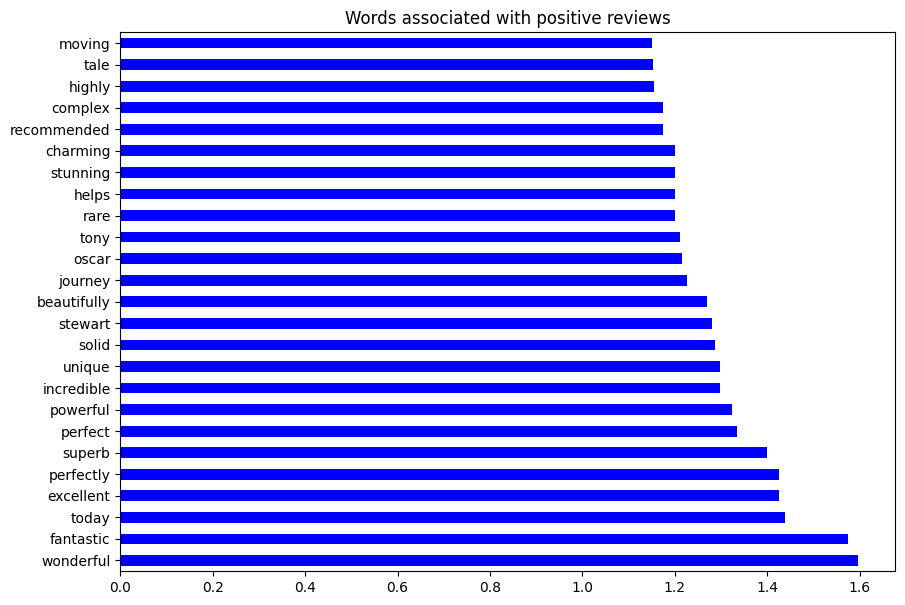

In [ ]:
top_pos_words = review_word_counts_llr.sort_values(ascending = False).head(25)

plt.figure(figsize = (10,7))
top_pos_words.plot(kind = 'barh', color = 'blue')
plt.title('Words associated with positive reviews');

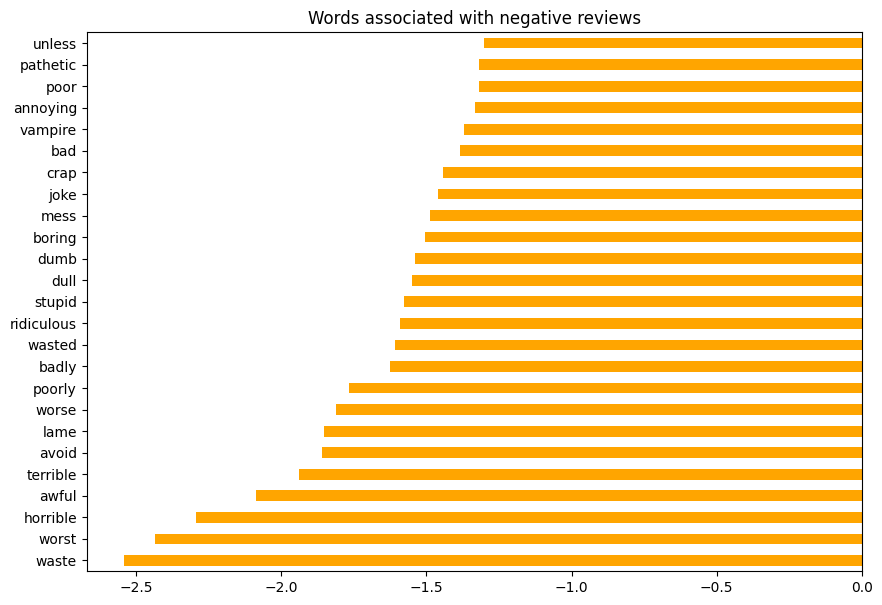

In [ ]:
top_neg_words = review_word_counts_llr.sort_values(ascending = True).head(25)

plt.figure(figsize = (10,7))
top_neg_words.plot(kind = 'barh', color = 'orange')
plt.title('Words associated with negative reviews');

### Others?

There may be other things you want to explore.  The crucial thing here is to look at the linguistics literature on affect, stance, etc.  This can help guide what you might want to look at.

# Evaluation Metric

How are we going to decide whether our system is performant or not?  We will use Macro F1 as that is fairly common in NLP, but you should be aware that other metrics (Brier, AUROC, ...) might be more appropriate for the problem.  

In [ ]:
from sklearn.metrics import f1_score

In [ ]:
!pip install tensorflow_addons

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 3108, in _dep_map
    return self.__dep_map
  File "/usr/local/lib/python3.10/dist-packages/pip/_vendor/pkg_resources/__init__.py", line 2901, in __getattr__
    raise AttributeError(attr)
AttributeError: _DistInfoDistribution__dep_map

During handling of the above exception, another exception occurred:

Traceback (most recent call last):
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/base_command.py", line 169, in exc_logging_wrapper
    status = run_func(*args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/cli/req_command.py", line 242, in wrapper
    return func(self, options, args)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 441, in run
    conflicts = self._determine_conflicts(to_install)
  File "/usr/local/lib/python3.10/dist-packages/pip/_internal/commands/install.py", line 

In [ ]:
from tensorflow_addons.metrics import F1Score

# Models

## Lexicon Approach

For our lexicon approach, we will use

Minqing Hu and Bing Liu. "Mining and Summarizing Customer Reviews."
;       Proceedings of the ACM SIGKDD International Conference on Knowledge
;       Discovery and Data Mining (KDD-2004), Aug 22-25, 2004, Seattle,
;       Washington, USA,

Original Positive words: 2006
Negative words: 4783
Useful properties: includes mis-spellings, morphological variants, slang, and social-media mark-up

See here for others: http://sentiment.christopherpotts.net/lexicons.html#resources

We are using a variant of it, which as P = 2003 and N = 4780, which removes words in the intersection of both.

In [ ]:
liu_lex = pd.read_csv("/content/drive/MyDrive/liu-sentiment-lexicon/liu-sentiment-lexicon.csv")

In [ ]:
# v simple preprocessing/text cleaning -----------------------------------------
def clean_review_for_lexicon_approach(r):

  # convert to string just in case
  r = str(r)

  # lower case
  r_lower = r.lower()

  # remove clausal punctuation
  r_clean = re.sub(r"[.,:;()]", "", r_lower)

  return r_clean

# simple tokenization splitting on whitespace ----------------------------------
def tokenize_review_for_lexicon_approach(r):

  # clean the text with the above function
  r = clean_review_for_lexicon_approach(r)

  # split it on whitespace
  r_split = r.split()

  # convert to a pandas series
  return pd.Series(r_split, name = 'word')


# get the sentiment ------------------------------------------------------------
def get_lexicon_based_sentiment(r):

  # tokenize the review
  tokenized_review = tokenize_review_for_lexicon_approach(r)

  # do a left join
  review_words_with_sentiment = pd.merge(left = tokenized_review, right = liu_lex, how = "left")

  # remove the NaNs
  review_words_with_sentiment = review_words_with_sentiment.dropna()

  # get the score (mean of the sentiment scores)
  score = np.mean(review_words_with_sentiment['sentiment'])

  # get a class

  if bool(score):
    if score > 0:
      return 'pos'
    elif score < 0:
      return 'neg'
    else:
      return random.choice(['pos', 'neg'])
  else:
    return random.choice(['pos', 'neg'])


In [ ]:
lex_model_train_preds = train_imdb['text'].apply(get_lexicon_based_sentiment)
lex_model_train_f1_score = f1_score(train_imdb['label'], lex_model_train_preds, average = 'macro')
print(f"Train F1-score using lexicon approach: {lex_model_train_f1_score:.4f}")

Train F1-score using lexicon approach: 0.7247


In [ ]:
lex_model_dev_preds = dev_imdb['text'].apply(get_lexicon_based_sentiment)
lex_model_dev_f1_score = f1_score(dev_imdb['label'], lex_model_dev_preds, average = 'macro')
print(f"Dev F1-score using lexicon approach: {lex_model_dev_f1_score:.4f}")

Dev F1-score using lexicon approach: 0.7233


## Traditional NLP

We will investigate (and tune) logistic regression on three (sparse) featurizations of the dataset:

i) unigram model

ii) unigram + bigram model

iii) unigram + bigram + hand-built features

### Preprocessing setup



To preprocess the data, we will:
* deal with negation;
* tokenize the text according to a sentiment-aware tokenizer;
* avoid stemming, case-folding, removal of stopwords.    

In [ ]:
from nltk.tokenize import TweetTokenizer, TreebankWordTokenizer

In [ ]:
potts_tokenizer = TweetTokenizer()
tb_tokenizer = TreebankWordTokenizer()

In [ ]:
potts_tokenizer.tokenize('@mygoodfriend That was good film :)')

['@mygoodfriend', 'That', 'was', 'good', 'film', ':)']

In [ ]:
tb_tokenizer.tokenize('@mygoodfriend That was good film :)')

['@', 'mygoodfriend', 'That', 'was', 'good', 'film', ':', ')']

In [ ]:
negation_list = ['not', 'never', 'no', 'nobody', 'noone', 'nowhere', 'never']

In [ ]:
def preprocess_and_tokenize_document(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = potts_tokenizer.tokenize(review)
  negated_review_tokenized = []


  negation_in_memory = 0
  for word in review_tokenized:
    if re.search('[.,:;]', word):
      negation_in_memory = 0
      negated_review_tokenized.append(word)
    elif "n't" in word or word in negation_list:
      negation_in_memory = 1
      negated_review_tokenized.append(word)
    else:
      if negation_in_memory == 1:
        negated_review_tokenized.append(word + '_NEG')
      else:
        negated_review_tokenized.append(word)

    # if "n't" in word or word in negation_list:
    #   print(word + "_NEG")

  return negated_review_tokenized

### Unigram Model

In [ ]:
from sklearn.feature_extraction.text import CountVectorizer

In [ ]:
unigram_vectorizer = CountVectorizer(
                                     lowercase = False,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (1,1),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
unigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

unigram_param_grid = {'C' : C_vals}

unigram_gridsearch = GridSearchCV(unigram_lr, unigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
unigram_pipeline = Pipeline(steps = [
    ("unigram_preprocessor_and_tokenizer", unigram_vectorizer),
    ("unigram_logit_gridsearch", unigram_gridsearch)
])

In [ ]:
unigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()
/usr/local/lib/python3.10/dist-packages/joblib/externals/loky/backend/fork_exec.py:38: RuntimeWarning: os.fork() was called. os.fork() is incompatible with multithreaded code, and JAX is multithreaded, so this will likely lead to a deadlock.
  pid = os.fork()


Pipeline(steps=[('unigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)),
                ('unigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
unigram_lr_train_preds = unigram_pipeline.predict(train_imdb['text'].values)
unigram_lr_train_f1_score = f1_score(train_imdb['label'], unigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams in logistic regression: {unigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams in logistic regression: 0.9857


In [ ]:
unigram_lr_dev_preds = unigram_pipeline.predict(dev_imdb['text'].values)
unigram_lr_dev_f1_score = f1_score(dev_imdb['label'], unigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams in logistic regression: {unigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams in logistic regression: 0.8584


### Bigram Model

In [ ]:
bigram_vectorizer = CountVectorizer(
                                     lowercase = False,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (2,2),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
bigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

bigram_param_grid = {'C' : C_vals}

bigram_gridsearch = GridSearchCV(bigram_lr, bigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
bigram_pipeline = Pipeline(steps = [
    ("bigram_preprocessor_and_tokenizer", bigram_vectorizer),
    ("bigram_logit_gridsearch", bigram_gridsearch)
])

In [ ]:
bigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('bigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 ngram_range=(2, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)),
                ('bigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
bigram_pipeline

Pipeline(steps=[('bigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, lowercase=False, min_df=10,
                                 ngram_range=(2, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)),
                ('bigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
bigram_lr_train_preds = bigram_pipeline.predict(train_imdb['text'].values)
bigram_lr_train_f1_score = f1_score(train_imdb['label'], bigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams in logistic regression: {bigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams in logistic regression: 0.9947


In [ ]:
bigram_lr_dev_preds = bigram_pipeline.predict(dev_imdb['text'].values)
bigram_lr_dev_f1_score = f1_score(dev_imdb['label'], bigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams in logistic regression: {bigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams in logistic regression: 0.8295


### Unigram + Bigram Model

In [ ]:
unibigram_vectorizer = CountVectorizer(
                                     lowercase = True,
                                     preprocessor = None,
                                     tokenizer = preprocess_and_tokenize_document,
                                     ngram_range = (1,2),
                                     min_df = 10,
                                     binary = True)

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
unibigram_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

unibigram_param_grid = {'C' : C_vals}

unibigram_gridsearch = GridSearchCV(unibigram_lr, unibigram_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
unibigram_pipeline = Pipeline(steps = [
    ("unibigram_preprocessor_and_tokenizer", unibigram_vectorizer),
    ("unibigram_logit_gridsearch", unibigram_gridsearch)
])

In [ ]:
unibigram_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('unibigram_preprocessor_and_tokenizer',
                 CountVectorizer(binary=True, min_df=10, ngram_range=(1, 2),
                                 tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)),
                ('unibigram_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
unibigram_pipeline[0]

CountVectorizer(binary=True, min_df=10, ngram_range=(1, 2),
                tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)

In [ ]:
len(unibigram_pipeline.steps[0][1].get_feature_names_out())

26505

In [ ]:
unibigram_pipeline.steps[1][1].best_estimator_

LogisticRegression(C=0.1, max_iter=10000)

In [ ]:
unibigram_lr_train_preds = unibigram_pipeline.predict(train_imdb['text'].values)
unibigram_lr_train_f1_score = f1_score(train_imdb['label'], unibigram_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams in logistic regression: {unibigram_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams in logistic regression: 0.9983


In [ ]:
unibigram_lr_dev_preds = unibigram_pipeline.predict(dev_imdb['text'].values)
unibigram_lr_dev_f1_score = f1_score(dev_imdb['label'], unibigram_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams in logistic regression: {unibigram_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams in logistic regression: 0.8699


### Hand-build Feature Model

We will investigate 5 features:

- length of the review
- number of words in Liu's positive lexicon, negative lexicon, and their ratio
- number of exclamation marks
- number of words with lengthening
- number of all caps  

In [ ]:
def phi_review_length(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = potts_tokenizer.tokenize(review)

  # get number of words
  return len(review_tokenized)


In [ ]:
def phi_liu_metrics(review):

  # tokenize it according to the TweetTokenizer
  review_tokenized = [w.lower() for w in potts_tokenizer.tokenize(review)]

  # convert into a series
  review_tokenized = pd.Series(review_tokenized, name = "word")

  # merge with the liu dataset
  review_words_with_sentiment = pd.merge(left = review_tokenized, right = liu_lex, how = "left")
  review_words_with_sentiment = review_words_with_sentiment.dropna()

  # class counts
  sentiment_class_counts = review_words_with_sentiment['sentiment'].value_counts()

  # number of positives
  try:
    num_pos = sentiment_class_counts[1] + 1
  except:
    num_pos = 1

  # number of negatives
  try:
    num_neg = sentiment_class_counts[-1] + 1
  except:
    num_neg = 1

  # vocabulary size
  vocab_size = len(set(review_tokenized))

  # augmented review length
  review_len = len(review_tokenized) + vocab_size

  # positive rate
  pos_rate = num_pos / review_len

  # negative rate
  neg_rate = num_neg / review_len

  # their ratio
  pos_neg_ratio = pos_rate / neg_rate


  return num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio

In [ ]:
def phi_number_of_exclams(review):
  return len(re.findall('!', review))

In [ ]:
def phi_number_of_letter_lenthenings(review):

  review_lower = review.lower()

  letter_lengthenings = []

  for letter in string.ascii_lowercase:
    letter_lengthenings.extend(re.findall(f"{letter}{{4,}}", review_lower))

  return len(letter_lengthenings)

In [ ]:
def phi_vector(review):

  # review length
  rev_len = phi_review_length(review)

  # liu metrics
  num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio = phi_liu_metrics(review)

  # exclamations
  num_exclams = phi_number_of_exclams(review)

  return rev_len, num_pos, pos_rate, num_neg, neg_rate, pos_neg_ratio, num_exclams



In [ ]:
def phi_matrix(reviews):

  feature_matrix = np.zeros(shape = (len(reviews), len(phi_vector(reviews[0]))))

  for i, review in enumerate(reviews):
    feature_matrix[i,:] = phi_vector(review)

  return feature_matrix

In [ ]:
from sklearn.base import BaseEstimator, TransformerMixin
from sklearn.utils.validation import check_is_fitted


class PhiFeaturizer(BaseEstimator, TransformerMixin):
    # initializer
    def __init__(self):
        # save the features list internally in the class
        self.phi_feature_names = ["PHI_" + f for f in ["rev_len", "num_pos", \
                                                       "pos_rate", "num_neg", "neg_rate", \
                                                       "pos_neg_ratio", "num_exclams"]]

    def fit(self, X, y = None):
        return self

    def transform(self, X, y = None):
        # return the dataframe with the specified features
        return phi_matrix(X)

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import MinMaxScaler

In [ ]:
handcrafted_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

handcrafted_param_grid = {'C' : C_vals}

handcrafted_gridsearch = GridSearchCV(handcrafted_lr, handcrafted_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.pipeline import Pipeline
handcrafted_pipeline = Pipeline(steps = [
    ("handcrafted_featurizer", PhiFeaturizer()),
    ("handcrafted_scaler", MinMaxScaler()),
    ("handcrafted_logit_gridsearch", handcrafted_gridsearch)
])

In [ ]:
handcrafted_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

Pipeline(steps=[('handcrafted_featurizer', PhiFeaturizer()),
                ('handcrafted_scaler', MinMaxScaler()),
                ('handcrafted_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
handcrafted_lr_train_preds = handcrafted_pipeline.predict(train_imdb['text'].values)
handcrafted_lr_train_f1_score = f1_score(train_imdb['label'], handcrafted_lr_train_preds, average = 'macro')
print(f"Train F1-score using headcrafted features in logistic regression: {handcrafted_lr_train_f1_score:.4f}")

Train F1-score using headcrafted features in logistic regression: 0.7333


In [ ]:
handcrafted_lr_dev_preds = handcrafted_pipeline.predict(dev_imdb['text'].values[:50])
handcrafted_lr_dev_f1_score = f1_score(dev_imdb['label'][:50], handcrafted_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using headcrafted features in logistic regression: {handcrafted_lr_dev_f1_score:.4f}")

Dev F1-score using headcrafted features in logistic regression: 0.7182


### Unigram + Bigram + Handbuilt

In [ ]:
from sklearn.pipeline import FeatureUnion

In [ ]:
all_features_preproc =  FeatureUnion([
                                     ("vectorizer", CountVectorizer(
                                                                  lowercase = True,
                                                                  preprocessor = None,
                                                                  tokenizer = preprocess_and_tokenize_document,
                                                                  ngram_range = (1,2),
                                                                  min_df = 10,
                                                                  binary = True)),
                                      ("handcrafted", PhiFeaturizer())
])

In [ ]:
from sklearn.linear_model import LogisticRegression

In [ ]:
all_features_lr = LogisticRegression(max_iter = 10000, penalty = 'l2')

In [ ]:
from sklearn.model_selection import GridSearchCV

C_vals =  [100, 50, 10, 1.0, 0.1, 0.01, 0.001]

all_features_param_grid = {'C' : C_vals}

all_features_gridsearch = GridSearchCV(all_features_lr, all_features_param_grid, scoring = 'f1_macro' , n_jobs = -1)

In [ ]:
from sklearn.preprocessing import MaxAbsScaler

In [ ]:
from sklearn.pipeline import Pipeline
all_features_pipeline = Pipeline(steps = [
    ("all_features_preprocessor_and_tokenizer", all_features_preproc),
    ("scaler", MaxAbsScaler()),
    ("all_features_logit_gridsearch", all_features_gridsearch)
])

In [ ]:
all_features_pipeline.fit(train_imdb['text'].values, train_imdb['label'].values)

/usr/local/lib/python3.10/dist-packages/sklearn/feature_extraction/text.py:528: UserWarning: The parameter 'token_pattern' will not be used since 'tokenizer' is not None'
  warnings.warn(


Pipeline(steps=[('all_features_preprocessor_and_tokenizer',
                 FeatureUnion(transformer_list=[('vectorizer',
                                                 CountVectorizer(binary=True,
                                                                 min_df=10,
                                                                 ngram_range=(1,
                                                                              2),
                                                                 tokenizer=<function preprocess_and_tokenize_document at 0x7cd180965900>)),
                                                ('handcrafted',
                                                 PhiFeaturizer())])),
                ('scaler', MaxAbsScaler()),
                ('all_features_logit_gridsearch',
                 GridSearchCV(estimator=LogisticRegression(max_iter=10000),
                              n_jobs=-1,
                              param_grid={'C': [100, 50, 10, 1.0, 0.1, 0.01,
                                                0.001]},
                              scoring='f1_macro'))])

In [ ]:
all_features_lr_train_preds = all_features_pipeline.predict(train_imdb['text'].values)
all_features_lr_train_f1_score = f1_score(train_imdb['label'], all_features_lr_train_preds, average = 'macro')
print(f"Train F1-score using unigrams+bigrams+handcrafted in logistic regression: {all_features_lr_train_f1_score:.4f}")

Train F1-score using unigrams+bigrams+handcrafted in logistic regression: 0.9982


In [ ]:
all_features_lr_dev_preds = all_features_pipeline.predict(dev_imdb['text'].values)
all_features_lr_dev_f1_score = f1_score(dev_imdb['label'], all_features_lr_dev_preds, average = 'macro')
print(f"Dev F1-score using unigrams+bigrams+handcrafted in logistic regression: {all_features_lr_dev_f1_score:.4f}")

Dev F1-score using unigrams+bigrams+handcrafted in logistic regression: 0.8714


### Results on the dev set

In [ ]:
model_names = ['unigram', 'bigram', 'unigram+bigram', 'hand-built', 'all']
data = ['train', 'dev']
results = [ [ unigram_lr_train_f1_score, unigram_lr_dev_f1_score],
            [ bigram_lr_train_f1_score, bigram_lr_dev_f1_score],
            [ unibigram_lr_train_f1_score, unibigram_lr_dev_f1_score],
            [ handcrafted_lr_train_f1_score, handcrafted_lr_dev_f1_score],
            [ all_features_lr_train_f1_score , all_features_lr_dev_f1_score],
          ]
pd.DataFrame(results, index = model_names, columns = data)

,train,dev
unigram,0.985666,0.858422
bigram,0.994666,0.829469
unigram+bigram,0.998333,0.869948
hand-built,0.733321,0.718196
all,0.998167,0.871441


### Model comparison of `unigram_lr_dev_f1_score` and `all_features_lr_dev_f1_score`

Options for comparing models are:
- McNemar's test

In [ ]:
all_features_lr_correct = all_features_lr_dev_preds == dev_imdb['label']
unigram_lr_correct = unigram_lr_dev_preds == dev_imdb['label']

In [ ]:
contingency_tab = pd.crosstab(all_features_lr_correct, unigram_lr_correct)

In [ ]:
from statsmodels.stats.contingency_tables import mcnemar

In [ ]:
result = mcnemar(contingency_tab, exact=True)

In [ ]:
print('statistic=%.3f, p-value=%.3f' % (result.statistic, result.pvalue))

statistic=63.000, p-value=0.042


### Error Analysis of `all_features_lr_dev_f1_score`

In [ ]:
for label in ['pos', 'neg']:
  for text, _ in dev_imdb[(~all_features_lr_correct) & (dev_imdb['label'] == label)].sample(5, random_state = 12).itertuples(index = False):
    print(f"LABEL: {label}")
    print(text)
    print('------------------------------------------------------\n')

LABEL: pos
The 1967 In Cold Blood was perhaps more like "the real thing" (Think about it: would we really want to see the real thing?), but it was black and white in a color world, and a lot of people didn't even know what it was, and there was an opportunity to remake it for television. Plus, if you remake it, you can show some stuff not shown in the original. The book In Cold Blood by Truman Capote was the first "nonfiction novel". Truman's book was in fact not 100% true to the real story. I thought the Canadian location sufficed for Kansas pretty much for a TV movie. Look for the elements of sex, drugs and rock 'n' roll: Dick's womanizing, Perry being an aspirin junkie, Perry playing blues guitar.
------------------------------------------------------

LABEL: pos
"The Ladies Man" suffers a common problem among movies based on "Saturday Night Live" skits. And that is, a sketch that usually succeeds in five minutes will not do so well in ninety minutes. Although this movie does have i

## Neural/Deep NLP

### Averaged Word Embeddings



In [ ]:
import multiprocessing
from gensim.models import Word2Vec
import spacy
import random

#### Bespoke vectors (Word2Vec)

> N.B. Word2Vec is not technically a **neural** learning algorithm. It is based on a simple logistic regression.  But it's typically lumped under the neural approaches to NLP.

In [ ]:
w2v_model = Word2Vec(min_count=5,
                     vector_size = 100,
                     window=5,
                     negative=15,
                     sg=0,
                     workers = multiprocessing.cpu_count())

In [ ]:
spacy.require_gpu()
nlp = spacy.load('en_core_web_sm')

train_imdb_tokens = []
for doc in nlp.pipe(train_imdb['text'].values):
  train_imdb_tokens.append([t.text.lower() for t in doc])

dev_imdb_tokens = []
for doc in nlp.pipe(dev_imdb['text'].values):
  dev_imdb_tokens.append([t.text.lower() for t in doc])

test_imdb_tokens = []
for doc in nlp.pipe(test_imdb['text'].values):
  test_imdb_tokens.append([t.text.lower() for t in doc])

In [ ]:
example_id = random.randint(a=0, b = len(train_imdb))
train_imdb_tokens[example_id][:10]

['i', 'just', 'watched', 'this', 'movie', 'and', 'i', "'ve", 'got', 'ta']

In [ ]:
w2v_model.build_vocab(train_imdb_tokens)

In [ ]:
w2v_model.wv['movies'] # currently random

array([ 0.00972425, -0.00113141, -0.00702297, -0.00203539,  0.00609566,
        0.00172319,  0.00147087,  0.00182519,  0.00594567, -0.00322304,
        0.00935239,  0.00387275,  0.00232262, -0.00394478, -0.00835901,
        0.00082546, -0.00312544, -0.00973298, -0.00564231, -0.00859975,
        0.00175456, -0.00832814,  0.00467713,  0.00237465,  0.00635734,
        0.00030658,  0.00738721, -0.00279142, -0.00198896, -0.00257633,
       -0.00979148,  0.00797476, -0.00884065,  0.00453039, -0.00060483,
       -0.00457082,  0.00459354, -0.00297342,  0.00130716,  0.00905913,
        0.00560406, -0.00236014, -0.00214333,  0.00014315, -0.00209849,
        0.00467608,  0.00369906, -0.00547406,  0.0095477 ,  0.00298448,
        0.00107886, -0.00531705, -0.00581873,  0.00720453,  0.00202043,
       -0.00167853,  0.0066582 ,  0.00953487,  0.00629491, -0.00871776,
        0.00676616,  0.00068176,  0.00305302, -0.00090746,  0.00012399,
       -0.0041735 , -0.00446759, -0.00751167, -0.00496302, -0.00

In [ ]:
w2v_model.wv.most_similar('movies') # currently random words

[('ships', 0.3825451135635376),
 ('likes', 0.35172322392463684),
 ('colors', 0.34478384256362915),
 ('cheech', 0.341118186712265),
 ('chong', 0.3308126926422119),
 ('massive', 0.3288927376270294),
 ('solve', 0.323356032371521),
 ('tonight', 0.31997403502464294),
 ('hammy', 0.31638652086257935),
 ('insist', 0.31461265683174133)]

In [ ]:
w2v_model.train(train_imdb_tokens, total_examples=w2v_model.corpus_count, epochs=20)

(22354281, 32654600)

In [ ]:
w2v_model.wv.most_similar('movies') # seems to be learning something useful about word meaning!

[('films', 0.8938843011856079),
 ('flicks', 0.7389309406280518),
 ('comedies', 0.6786540746688843),
 ('westerns', 0.6238583922386169),
 ('documentaries', 0.5924127101898193),
 ('cartoons', 0.5744126439094543),
 ('examples', 0.5720182061195374),
 ('sequels', 0.5697360634803772),
 ('episodes', 0.5660054683685303),
 ('things', 0.5415089726448059)]

In [ ]:
# w2v_model.wv.most_similar('inflation') # if word not in training data, you get a key error

In [ ]:
# get word embeddings for training data

def get_word_embeddings(model, data, keyed=False):
  '''
  Gets the summarized word embeddings for the data
  INPUTS:
    data: the list of tokens in the document
    summarize: either 'mean' or 'max'
  OUTPUT:
    vector - ndim from the model
  '''

  token_matrix = []
  if not keyed:
    for token in data:
      try:
        token_matrix.append(model.wv[token])
      except: # see cell above
        pass
    if token_matrix:
      return np.array(token_matrix).mean(axis = 0)
    else:
      return np.zeros(model.vector_size)
  else:
    for token in data:
      try:
        token_matrix.append(model[token])
      except: # see cell above
        pass
    if token_matrix:
      return np.array(token_matrix).mean(axis = 0)
    else:
      return np.zeros(model.vector_size)


In [ ]:
example_embeds_mean = get_word_embeddings(w2v_model, train_imdb_tokens[0])
example_embeds_mean

array([-1.1334231e-01, -3.9511469e-01,  8.2574499e-01,  9.2242379e-04,
       -5.7771724e-01,  5.5657554e-01, -1.5646856e-01, -8.7160510e-01,
        8.4054969e-02,  1.1122791e+00,  6.6736937e-01,  1.0917974e+00,
        2.5379789e-01, -9.5529974e-01, -4.0779045e-01,  8.6104363e-01,
       -2.1186617e-01,  3.6354253e-01, -1.7827281e-01, -2.3409714e-01,
       -1.3169334e-02, -2.7839211e-01, -6.8900520e-01, -2.9328063e-01,
       -5.7218117e-01, -8.0026582e-02,  4.3921578e-01, -5.1065481e-01,
       -3.7989851e-02, -1.2111787e-01, -3.0202997e-01,  1.7275397e-01,
       -1.6615881e-01,  3.6215588e-01,  1.3220951e-01, -6.9607008e-01,
       -3.4182003e-01, -1.0998958e-01, -3.1858727e-01,  6.7548585e-01,
        4.7216031e-01, -5.4586321e-01, -1.5797949e-01,  4.7849050e-01,
       -4.9746972e-01, -2.9249126e-01, -1.5839428e-01,  5.2168816e-01,
        2.4468699e-02,  6.3565537e-02, -5.6890089e-02,  3.4628829e-01,
        5.4999103e-04,  3.2145107e-01,  1.9097422e-01, -3.8498670e-01,
      

In [ ]:
example_embeds_mean.shape

(100,)

In [ ]:
training_mean_embeds = np.array([get_word_embeddings(w2v_model, review) for review in train_imdb_tokens])
dev_mean_embeds = np.array([get_word_embeddings(w2v_model, review) for review in dev_imdb_tokens])
test_mean_embeds = np.array([get_word_embeddings(w2v_model, review) for review in test_imdb_tokens])

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

mean_embeds_logit = LogisticRegression(max_iter=10000)
mean_embeds_logit.fit(training_mean_embeds, train_imdb['label'].values)
mean_embeds_dev_preds = mean_embeds_logit.predict(dev_mean_embeds)
mean_embeds_lr_dev_f1_score = f1_score(dev_imdb['label'], mean_embeds_dev_preds, average = 'macro')
mean_embeds_lr_dev_f1_score

0.8309389689677974

#### Pretrained vectors (GloVe)

Gensim ships with many pretrained word vectors.

In [ ]:
import gensim.downloader

for model in gensim.downloader.info()['models'].keys():
  print(model)

fasttext-wiki-news-subwords-300
conceptnet-numberbatch-17-06-300
word2vec-ruscorpora-300
word2vec-google-news-300
glove-wiki-gigaword-50
glove-wiki-gigaword-100
glove-wiki-gigaword-200
glove-wiki-gigaword-300
glove-twitter-25
glove-twitter-50
glove-twitter-100
glove-twitter-200
__testing_word2vec-matrix-synopsis


We'll look at:

- glove-wiki-gigaword-100


In [ ]:
glove_100_vectors = gensim.downloader.load('glove-wiki-gigaword-100')

[==================================================] 100.0% 128.1/128.1MB downloaded


In [ ]:
glove_100_vectors.vector_size

100

In [ ]:
glove_100_vectors['movies']

array([ 0.20318 , -0.038519,  0.36747 , -0.47398 ,  0.54958 ,  0.14834 ,
       -0.57758 , -0.45752 , -0.096795, -0.21906 ,  0.36106 , -0.31937 ,
       -0.21593 ,  0.34316 ,  0.19269 ,  0.17855 ,  0.35723 ,  0.58114 ,
        0.49389 ,  1.418   ,  0.76268 ,  0.21746 ,  0.2875  , -0.40226 ,
        0.51873 ,  0.24935 ,  0.48152 ,  0.083086, -0.27378 ,  0.029043,
        0.43288 ,  0.59491 , -0.45899 , -0.01076 ,  0.81939 ,  0.69779 ,
        0.20967 , -0.39015 , -0.48743 , -0.52194 ,  0.21541 ,  0.59994 ,
       -1.2503  ,  0.3561  ,  0.097817, -0.51304 , -0.3622  , -0.95114 ,
        0.48781 , -0.39364 , -0.20997 , -0.50353 ,  0.18934 ,  0.58658 ,
        0.37526 , -1.6841  , -0.3164  ,  0.96816 ,  1.2753  ,  0.015298,
       -0.39232 ,  2.4491  , -0.14734 , -0.57761 ,  0.50913 ,  0.41404 ,
        1.1141  ,  0.25135 , -0.35589 ,  0.41739 ,  0.67043 , -0.22274 ,
        0.22604 ,  0.67876 , -0.79047 ,  0.11936 , -0.45199 ,  0.40964 ,
       -0.36133 , -0.23893 , -0.30886 , -0.2739  , 

In [ ]:
glove_100_vectors.most_similar('movies')

[('films', 0.914044976234436),
 ('movie', 0.895932674407959),
 ('film', 0.7889865040779114),
 ('hollywood', 0.7580320239067078),
 ('comedies', 0.7401068806648254),
 ('comedy', 0.7259803414344788),
 ('dramas', 0.7213095426559448),
 ('tv', 0.7155946493148804),
 ('documentaries', 0.7105302214622498),
 ('videos', 0.7034313678741455)]

In [ ]:
training_mean_glove_embeds = np.array([get_word_embeddings(glove_100_vectors, review, keyed=True) for review in train_imdb_tokens])
dev_mean_glove_embeds = np.array([get_word_embeddings(glove_100_vectors, review, keyed=True) for review in dev_imdb_tokens])
test_mean_glove_embeds = np.array([get_word_embeddings(glove_100_vectors, review, keyed=True) for review in test_imdb_tokens])

In [ ]:
training_mean_glove_embeds.shape

(6000, 100)

In [ ]:
training_mean_glove_embeds[0]

array([-0.11828782,  0.1989572 ,  0.39381486, -0.35690662, -0.13739882,
        0.19712806, -0.12322772,  0.15742075, -0.05132868, -0.05816779,
        0.16206902, -0.03891039,  0.22174294,  0.04558257,  0.18132102,
       -0.20404053,  0.18852974,  0.144567  , -0.32479462,  0.328559  ,
        0.2815716 , -0.03829998,  0.17104407, -0.03854465,  0.30780613,
        0.07166793, -0.08602642, -0.46325296,  0.05870955, -0.17678702,
       -0.05528191,  0.44895935, -0.05443738,  0.07221399,  0.11935463,
        0.26125082,  0.02580668,  0.22708932,  0.05483676, -0.25686917,
       -0.30149522, -0.1759669 ,  0.05327263, -0.2780731 , -0.08274836,
       -0.0428144 ,  0.16072181, -0.30471432, -0.03673794, -0.63942933,
       -0.06190938, -0.05651054,  0.14605546,  1.0537689 , -0.2415922 ,
       -2.277287  , -0.01487697, -0.02979167,  1.3590642 ,  0.4663354 ,
       -0.139244  ,  0.8210305 , -0.2808156 ,  0.09878747,  0.7912388 ,
       -0.04278139,  0.5507268 ,  0.3335041 ,  0.08572368, -0.10

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score

mean_glove_embeds_logit = LogisticRegression(max_iter=10000)
mean_glove_embeds_logit.fit(training_mean_glove_embeds, train_imdb['label'].values)
mean_glove_embeds_dev_preds = mean_glove_embeds_logit.predict(dev_mean_glove_embeds)
mean_glove_embeds_lr_dev_f1_score = f1_score(dev_imdb['label'], mean_glove_embeds_dev_preds, average = 'macro')
mean_glove_embeds_lr_dev_f1_score

0.7879980919828278

### Document Embeddings (Doc2Vec)

In [ ]:
from gensim.models.doc2vec import (TaggedDocument,
                                   Doc2Vec)

In [ ]:
train_imdb_tokens_doc2vec = [TaggedDocument(tokens, [i]) for i, tokens in enumerate(train_imdb_tokens)]


In [ ]:
train_imdb_tokens_doc2vec[0]

TaggedDocument(words=['while', 'the', 'idea', 'is', 'more', 'original', 'than', 'most', 'sci', '-', 'fi', 'movies', ',', 'the', 'execution', 'is', ',', 'as', 'usual', 'lacking', '.', 'while', 'the', 'practical', 'mummy', 'effects', 'are', 'not', 'bad', ',', 'and', 'the', '"', 'gun', 'nut', '"', 'character', 'is', 'over', 'the', 'top', 'giggle', 'inducing', ',', 'the', 'only', 'real', 'draw', 'is', 'to', 'see', 'morena', 'baccarin', 'and', 'adam', 'baldwin', 'reunited', 'on', 'the', 'small', 'screen', '.', 'i', 'suspect', 'that', 'was', 'the', 'idea', 'all', 'along', '.', 'they', 'do', 'the', 'best', 'they', 'can', 'with', 'what', 'they', 'have', 'but', 'the', '"', 'must', 'see', '"', 'moments', 'for', 'me', 'were', 'in', 'the', 'first', '40', 'minutes', 'or', 'so', 'when', 'morena', "'s", 'character', 'sported', 'some', 'tomb', 'raider', 'style', 'shorts', '.', 'not', 'high', 'brow', 'cinema', 'i', 'know', 'but', 'you', 'ca', "n't", 'deny', 'true', 'beauty', 'when', 'you', 'see', 'it',

In [ ]:
d2v_model = Doc2Vec(min_count=5,
                     vector_size = 100,
                     window=5,
                     negative=15,
                     workers = multiprocessing.cpu_count())

In [ ]:
d2v_model.build_vocab(train_imdb_tokens_doc2vec)

In [ ]:
d2v_model.train(train_imdb_tokens_doc2vec,
                total_examples=d2v_model.corpus_count,
                epochs=d2v_model.epochs)

In [ ]:
d2v_model.wv.most_similar('movies')

[('films', 0.921156644821167),
 ('flicks', 0.778674304485321),
 ('comedies', 0.7508681416511536),
 ('westerns', 0.6859201192855835),
 ('cartoons', 0.6447525024414062),
 ('masters', 0.6196814179420471),
 ('episodes', 0.6013810634613037),
 ('sequels', 0.600577712059021),
 ('examples', 0.5841297507286072),
 ('cinema', 0.5805022716522217)]

In [ ]:
training_d2v_embeds = np.array([d2v_model.infer_vector(tokens) for tokens in train_imdb_tokens])
dev_d2v_embeds = np.array([d2v_model.infer_vector(tokens) for tokens in dev_imdb_tokens])
test_d2v_embeds = np.array([d2v_model.infer_vector(tokens) for tokens in test_imdb_tokens])

In [ ]:
training_d2v_embeds.shape, dev_d2v_embeds.shape, test_d2v_embeds.shape

((6000, 100), (2000, 100), (2000, 100))

In [ ]:
doc2vec_embeds_logit = LogisticRegression(max_iter=10000)
doc2vec_embeds_logit.fit(training_d2v_embeds, train_imdb['label'].values)
doc2vec_embeds_dev_preds = doc2vec_embeds_logit.predict(dev_d2v_embeds)
doc2vec_embeds_lr_dev_f1_score = f1_score(dev_imdb['label'], doc2vec_embeds_dev_preds, average = 'macro')
doc2vec_embeds_lr_dev_f1_score

0.8168762083168222

### Contextual Embeddings (BERT family)

#### Off-the-shelf

First we'll use an off-the-shelf sentiment classification model.

In [ ]:
!pip install transformers[torch] datasets

NotImplementedError: A UTF-8 locale is required. Got ANSI_X3.4-1968

In [ ]:
import transformers, torch, datasets

In [ ]:
from transformers import pipeline

ots_sentiment_pipeline = pipeline("sentiment-analysis", padding = True, truncation = True, device = "cuda:0")


In [ ]:
ots_sentiment_pipeline('I love this movie')

In [ ]:
ots_sentiment_pipeline(train_imdb['text'][0])

In [ ]:
ots_raw_predictions_dev = ots_sentiment_pipeline(dev_imdb['text'].tolist())

In [ ]:
ots_raw_predictions_dev[:4], dev_imdb['label'].iloc[:4]

In [ ]:
# let's make the predicted labels like our own labels
ots_predictions_dev = [pred['label'].lower()[:3] for pred in ots_raw_predictions_dev]

In [ ]:
ots_predictions_dev[:4]

In [ ]:
dev_imdb['label']

In [ ]:
ots_sentiment_f1 = f1_score(dev_imdb['label'], ots_predictions_dev, average = 'macro')
ots_sentiment_f1

## Fine-tuning

In [ ]:
from datasets import Dataset, DatasetDict

In [ ]:
id2label = {0: "neg", 1: "pos"}
label2id = {"neg": 0, "pos": 1}

In [ ]:
data_dict = DatasetDict({'train' : Dataset.from_dict({'text' : train_imdb['text'].values,
                                                      'label' : train_imdb['label'].map(label2id).values}),

                        'dev' : Dataset.from_dict({'text' : dev_imdb['text'].values,
                                                   'label' : dev_imdb['label'].map(label2id).values}),

                        'test' : Dataset.from_dict({'text' : test_imdb['text'].values,
                                                   'label' : test_imdb['label'].map(label2id).values}),
})
data_dict

In [ ]:
data_dict['train'][0]

In [ ]:
# load the tokenizer, model

from transformers import AutoTokenizer, AutoModelForSequenceClassification
checkpoint = "distilbert/distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(checkpoint)
model = AutoModelForSequenceClassification.from_pretrained(checkpoint)

In [ ]:
# tokenize the sequences, batching

tokenized_example = tokenizer(data_dict['train']['text'][123], padding = True, truncation = True)
tokenized_example

In [ ]:
tokenizer.convert_ids_to_tokens(tokenized_example['input_ids'])

In [ ]:
def tokenize_function(example):
  return tokenizer(example['text'], truncation=True)

In [ ]:
tokenized_datasets = data_dict.map(tokenize_function, batched=True)

In [ ]:
from transformers import DataCollatorWithPadding

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)

In [ ]:
from transformers import AutoModelForSequenceClassification, TrainingArguments, Trainer

model = AutoModelForSequenceClassification.from_pretrained(
    "distilbert/distilbert-base-uncased", num_labels=2, id2label=id2label, label2id=label2id
)

In [ ]:
training_args = TrainingArguments(
    output_dir="fine-tuned sentiment model",
    learning_rate=2e-5,
    per_device_train_batch_size=16,
    per_device_eval_batch_size=16,
    num_train_epochs=3,
    weight_decay=0.01,
    eval_strategy="epoch",
    save_strategy="epoch",
    load_best_model_at_end=True,
    push_to_hub=False,
)

trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=tokenized_datasets["train"],
    eval_dataset=tokenized_datasets["dev"],
    tokenizer=tokenizer,
    data_collator = data_collator
)

trainer.train()

In [ ]:
ft_dev_raw_predictions = trainer.predict(tokenized_datasets['dev'])
ft_dev_predictions = pd.Series(ft_dev_raw_predictions.predictions.argmax(axis = 1)).map(id2label)

In [ ]:
ft_sentiment_f1 = f1_score(dev_imdb['label'], ft_dev_predictions, average = 'macro')
ft_sentiment_f1